In [1]:
import polars as pl
import numpy as np

# 读取数据
data = pl.read_parquet("daily_data.pa")

df = data.sort('open_time').sort('symbol')

N = 50

df

open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,symbol
datetime[μs],f64,f64,f64,f64,f64,datetime[μs],f64,i64,f64,f64,str
2023-11-22 00:00:00,0.00478,0.004825,0.004076,0.004531,1.2701e10,2023-11-22 23:59:59.999,5.6368e7,320715,6.1849e9,2.7467e7,"""1000BONKUSDT"""
2023-11-23 00:00:00,0.004531,0.004858,0.00393,0.004267,1.8971e10,2023-11-23 23:59:59.999,8.1590e7,573386,8.8982e9,3.8318e7,"""1000BONKUSDT"""
2023-11-24 00:00:00,0.004267,0.004335,0.003835,0.00414,1.7169e10,2023-11-24 23:59:59.999,6.9929e7,475254,7.9410e9,3.2393e7,"""1000BONKUSDT"""
2023-11-25 00:00:00,0.004143,0.0046,0.004084,0.00434,1.3093e10,2023-11-25 23:59:59.999,5.6988e7,501832,6.3891e9,2.7819e7,"""1000BONKUSDT"""
2023-11-26 00:00:00,0.004341,0.004473,0.0039,0.004039,8.2273e9,2023-11-26 23:59:59.999,3.4347e7,344203,3.8247e9,1.5980e7,"""1000BONKUSDT"""
…,…,…,…,…,…,…,…,…,…,…,…
2024-03-08 00:00:00,0.5161,0.5819,0.4875,0.5575,1.8804e8,2024-03-08 23:59:59.999,1.0033e8,686024,8.9756e7,4.7898e7,"""ZRXUSDT"""
2024-03-09 00:00:00,0.5576,0.6067,0.5397,0.5785,9.4661e7,2024-03-09 23:59:59.999,5.3586e7,380425,4.6599725e7,2.6364e7,"""ZRXUSDT"""
2024-03-10 00:00:00,0.5785,0.8259,0.5671,0.8005,7.80136805e8,2024-03-10 23:59:59.999,5.9270e8,2616066,3.9341e8,2.9910e8,"""ZRXUSDT"""


In [2]:
df = df.with_columns([
    pl.col('quote_volume').rolling_sum(N).over('symbol').alias('quote_volume_sum'),
    (pl.col('close') / (pl.col('close').shift(1).over('symbol')) - 1).alias('return')
])

In [3]:
df = df.with_columns([(pl.col('volume') * pl.col('close') * (pl.col('close') - pl.col('close').shift(1))
                      / (pl.col('close') - pl.col('close').shift(1)).abs() / pl.col('quote_volume_sum'))
                      .over('symbol').alias('money_flow')])

df

open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,symbol,quote_volume_sum,return,money_flow
datetime[μs],f64,f64,f64,f64,f64,datetime[μs],f64,i64,f64,f64,str,f64,f64,f64
2023-11-22 00:00:00,0.00478,0.004825,0.004076,0.004531,1.2701e10,2023-11-22 23:59:59.999,5.6368e7,320715,6.1849e9,2.7467e7,"""1000BONKUSDT""",null,null,null
2023-11-23 00:00:00,0.004531,0.004858,0.00393,0.004267,1.8971e10,2023-11-23 23:59:59.999,8.1590e7,573386,8.8982e9,3.8318e7,"""1000BONKUSDT""",null,-0.058265,null
2023-11-24 00:00:00,0.004267,0.004335,0.003835,0.00414,1.7169e10,2023-11-24 23:59:59.999,6.9929e7,475254,7.9410e9,3.2393e7,"""1000BONKUSDT""",null,-0.029763,null
2023-11-25 00:00:00,0.004143,0.0046,0.004084,0.00434,1.3093e10,2023-11-25 23:59:59.999,5.6988e7,501832,6.3891e9,2.7819e7,"""1000BONKUSDT""",null,0.048309,null
2023-11-26 00:00:00,0.004341,0.004473,0.0039,0.004039,8.2273e9,2023-11-26 23:59:59.999,3.4347e7,344203,3.8247e9,1.5980e7,"""1000BONKUSDT""",null,-0.069355,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-03-08 00:00:00,0.5161,0.5819,0.4875,0.5575,1.8804e8,2024-03-08 23:59:59.999,1.0033e8,686024,8.9756e7,4.7898e7,"""ZRXUSDT""",2.0786e9,0.080426,0.050435
2024-03-09 00:00:00,0.5576,0.6067,0.5397,0.5785,9.4661e7,2024-03-09 23:59:59.999,5.3586e7,380425,4.6599725e7,2.6364e7,"""ZRXUSDT""",2.1192e9,0.037668,0.025841
2024-03-10 00:00:00,0.5785,0.8259,0.5671,0.8005,7.80136805e8,2024-03-10 23:59:59.999,5.9270e8,2616066,3.9341e8,2.9910e8,"""ZRXUSDT""",2.7054e9,0.383751,0.230837


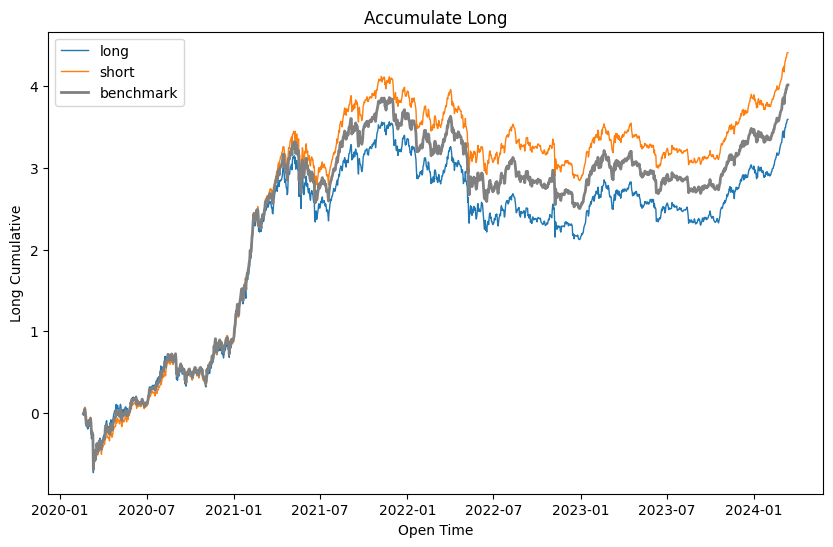

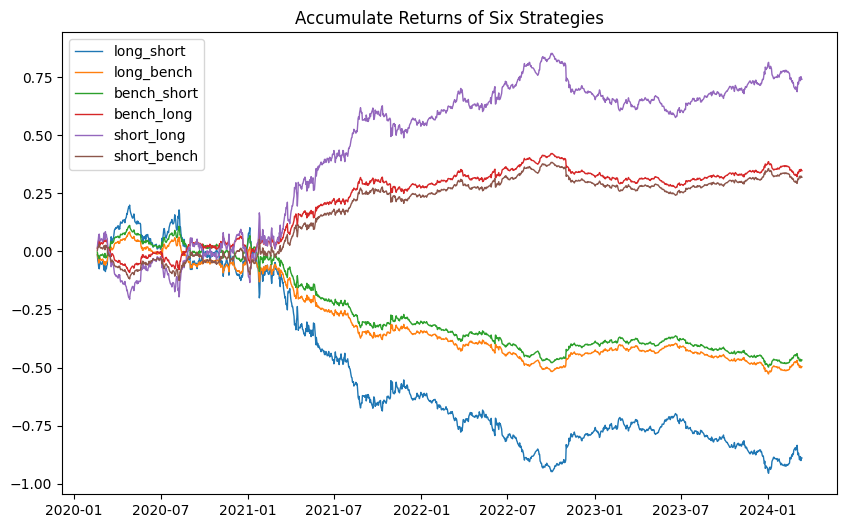

long: 
ann_return = 21.1984  sharpe = 4.6386  maxdd = 0.7288  calmar_ratio = 29.085  

short: 
ann_return = 26.0098  sharpe = 5.7371  maxdd = 0.694  calmar_ratio = 37.4762  

bench: 
ann_return = 23.6885  sharpe = 5.2512  maxdd = 0.7036  calmar_ratio = 33.6675  

long_short: 
ann_return = -5.2494  sharpe = -4.2645  maxdd = 0.9625  calmar_ratio = -5.4541  

long_bench: 
ann_return = -2.9281  sharpe = -4.7155  maxdd = 0.5642  calmar_ratio = -5.1898  

bench_long: 
ann_return = 2.0521  sharpe = 3.3048  maxdd = 0.1404  calmar_ratio = 14.6126  

short_long: 
ann_return = 4.3734  sharpe = 3.5529  maxdd = 0.2684  calmar_ratio = 16.2971  

short_bench: 
ann_return = 1.8833  sharpe = 3.06  maxdd = 0.1519  calmar_ratio = 12.3981  

bench_short: 
ann_return = -2.7593  sharpe = -4.4833  maxdd = 0.5486  calmar_ratio = -5.03  



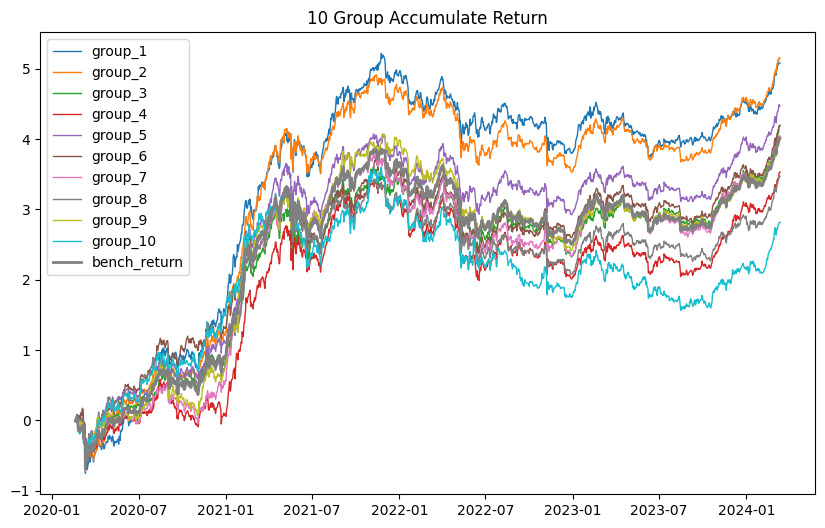

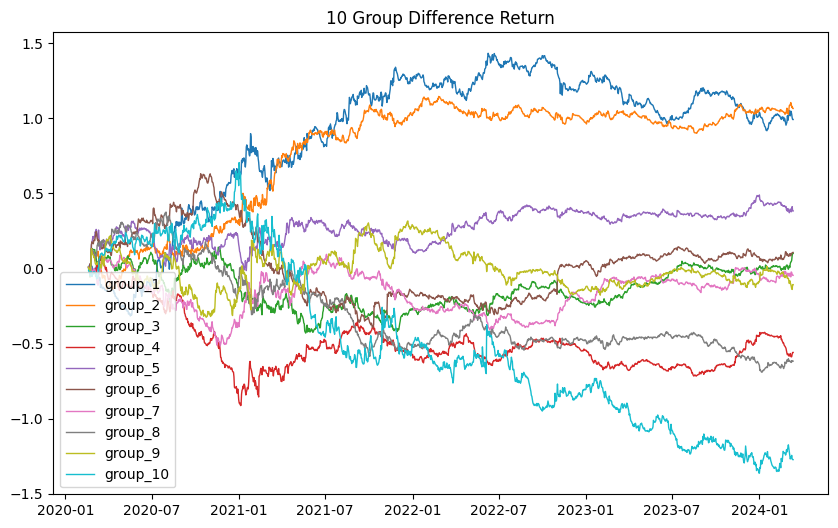

group_1: 
ann_return = 29.98  sharpe = 6.0971  maxdd = 0.7691  calmar_ratio = 38.9822  

group_2: 
ann_return = 30.4144  sharpe = 6.5431  maxdd = 0.6179  calmar_ratio = 49.224  

group_3: 
ann_return = 24.7204  sharpe = 5.343  maxdd = 0.6679  calmar_ratio = 37.0122  

group_4: 
ann_return = 20.8263  sharpe = 4.4391  maxdd = 0.6374  calmar_ratio = 32.6744  

group_5: 
ann_return = 26.3856  sharpe = 5.7324  maxdd = 0.515  calmar_ratio = 51.2366  

group_6: 
ann_return = 24.7559  sharpe = 5.2382  maxdd = 0.599  calmar_ratio = 41.3302  

group_7: 
ann_return = 23.8569  sharpe = 5.0595  maxdd = 0.7304  calmar_ratio = 32.6631  

group_8: 
ann_return = 20.4847  sharpe = 4.345  maxdd = 0.5502  calmar_ratio = 37.2286  

group_9: 
ann_return = 23.4923  sharpe = 4.6937  maxdd = 0.6643  calmar_ratio = 35.3621  

group_10: 
ann_return = 16.615  sharpe = 3.2548  maxdd = 0.711  calmar_ratio = 23.3693  

-----------------------------------------
group_difference_1: 
ann_return = 5.8535  sharpe = 3.136

In [4]:
factors = df.select(['open_time', 'symbol', 'money_flow'])
# 对 factors drop NaN
factors = factors.fill_nan(None).drop_nulls()

from factor_analysis.factor_analysis import FactorAnalysis

# 使用示例
analysis = FactorAnalysis(factors, data)
analysis.run_full_analysis()